In [1]:
from __future__ import absolute_import, division, print_function
import glob
import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import pdb
import json
import getpass
from scipy import stats
from sklearn import linear_model
from numpy import linalg as LA
import numpy.random as npr
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.manifold import MDS
from scipy.spatial import distance
from sklearn.cluster import KMeans
import imageio

ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
    PATH_NET = os.path.join(p,'code/sequential_multiTask_RNN')
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
    PATH_NET = os.path.join(p,'code/sequential_multiTask_RNN')
elif ui == 'lndrisco':
    p = '/home/users/lndrisco'
    PATH_NET = os.path.join(p,'code/sequential_multiTask_RNN')

if ui == 'leaduncker':
    p = '/Users/leaduncker/Documents/'
    PATH_NET = os.path.join(p,'git/sequential_multiTask_RNN')

sys.path.insert(0, PATH_NET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, FixedPoint_Model
import tools
from tools_lnd import generate_Beta_epoch, get_T_inds, add_ax_labels, TDR_axes, eigenspectrum_axes, out_axes
from tools_lnd import make_h_trial_rule, comp_eig_decomp, plot_FP, get_model_params, take_names
from tools_lnd import make_fp_struct, make_fp_tdr_fig, make_h_trial_rule, get_D
sim_all_dir = 'data/rnn/sequential_multiTask_RNN/trained_nets_lea/all_tasks_fixedBias/l2h_0.0000001_l2w_0.00001/'
seq_all_dir = 'data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/'

In [4]:
#output dynamics
dims ='tdr'
seq = True
fp_file = 'tf_fixed_pts_all_init'
n_letter = 'a'
n_number = 2

if seq == True:   
    all_dir = 'data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/'
    tit = 'sequential'
    m = os.path.join(p,all_dir,'goantiset',n_letter,str(n_number))
else:
    all_dir = seq_all_dir
    tit = 'simultaneous'
    m = os.path.join(p,all_dir,'goantiset',str(n_number))

h,trial,tasks = make_h_trial_rule(m)
w_in, b_in, w_out, b_out = get_model_params(m)

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/sequential

In [1]:
def plot_epoch_dynamics_animate(m,fp_file,epoch,h,trial,rule,D_use,
                        t_set = 0,h_epoch = [],lim=4, ax_type = 'tdr',
                        epoch_axes =[],stim_loc_fp = 0):
    
    LAG = 10
    lim=lim
    fig_title = rule + ' ' + epoch + '_combined'
    
    fldr = os.path.join(m,'epoch_dynamics_gif/')
    if not os.path.exists(fldr):
        os.makedirs(fldr)

    movie_dir = os.path.join(fldr,fig_title)
    if not os.path.exists(movie_dir):
        os.makedirs(movie_dir)


    xs = np.linspace(-1, 1, 1000)
    ys = np.sqrt(1 - xs**2)
    
    epoch_name, rule_name, epoch_axes_name, h_epoch = take_names(epoch,rule,epoch_axes = epoch_axes,
                                                                 h_epoch = h_epoch)

    cmap = plt.get_cmap('hsv')
    
    stim1_locs = np.min(trial[rule].stim_locs[:,[0,2]],axis=1)
    y_locs = trial[rule].y_loc[-1,:]
    
    mov_i = 0
    fig = plt.figure(figsize=(10,5),tight_layout=True,facecolor='white')
    ax = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax2.plot(xs, ys,':k',linewidth = 1)
    ax2.plot(xs, -ys,':k',linewidth = 1)
    plt.xlim((.7,1.1))
    plt.ylim((-.15,.15))
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    eigenspectrum_axes(epoch,ax2)
    ax2.set_aspect('equal')
    
    for ti in range(len(t_set)):
        t = t_set[ti]
        c = cmap(stim1_locs[t]/(2*np.pi))

        T_inds = get_T_inds(trial[rule],h_epoch)
        h_tdr = np.empty((len(T_inds),np.shape(h[rule])[1]))
        print(np.shape(h[rule]))
        h_tdr_temp = np.squeeze(np.dot(h[rule][:,t,:],D_use))

        movie_inds = T_inds[0:-1:6]

        for im_num in movie_inds:
            
            ax = plt.subplot(121)
            ax.clear()
            
            for t_fp in t_set[0:ti]:
                c_fp = cmap(stim1_locs[t_fp]/(2*np.pi))
                fps_anti, J_xstar = make_fp_struct(m,fp_file,rule,epoch,int(stim1_locs[t_fp]*180/np.pi))
                eig_decomps = comp_eig_decomp(J_xstar)
                fps_tdr_anti = np.dot(fps_anti,D_use)
                plt.plot(fps_tdr_anti[:,0],fps_tdr_anti[:,1],'o',c=c_fp,alpha = .5,markersize=6)
            
            
            plot_set_start = np.max([T_inds[0],im_num-LAG])
            plot_set = range(plot_set_start,im_num)

            plt.plot(h_tdr_temp[plot_set,0],h_tdr_temp[plot_set,1],c = c,alpha = 1,linewidth = 3)
            plt.plot(h_tdr_temp[0,0],h_tdr_temp[0,1],'x',c = c,alpha = 1,
                     markersize = 10,linewidth = 2)


            ax = add_ax_labels(ax,ax_type,lim,epoch_axes_name,rule_name)
            plt.yticks((-5,0,5))

            plt.title(r"$\bf{" + rule_name + "}$"+ '\n '+epoch_name+' dynamics',y = .9)
            if ax_type!='mix':
                ax.set_aspect('equal')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            mov_i += 1 
            plt.savefig(movie_dir +'/'+ str(mov_i) + '.png')

        fps_anti, J_xstar = make_fp_struct(m,fp_file,rule,epoch,int(stim1_locs[t]*180/np.pi))
        eig_decomps = comp_eig_decomp(J_xstar)
        fps_tdr_anti = np.dot(fps_anti,D_use)
        plt.plot(fps_tdr_anti[:,0],fps_tdr_anti[:,1],'o',c='k',alpha = .5,markersize=6)

#         mov_i += 1 
#         plt.savefig(movie_dir +'/'+ str(im_num+1) + '.png')

#         plt.plot(fps_tdr_anti[:,0],fps_tdr_anti[:,1],'o',c=c,alpha = .5,markersize=6)
        
        ax2 = plt.subplot(122)
        for fp_num in range(np.shape(J_xstar)[0]):
            evals, _ = LA.eig(J_xstar[fp_num,:,:]) 
            ax2.plot(evals.real,evals.imag,'.',c = c, alpha = .3,markerfacecolor = 'k')

#         ax2.plot(xs, ys,':k',linewidth = 1)
#         ax2.plot(xs, -ys,':k',linewidth = 1)
        plt.xlim((.7,1.1))
        plt.ylim((-.15,.15))
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        eigenspectrum_axes(epoch,ax2)
        ax2.set_aspect('equal')  
        mov_i += 1 
        plt.savefig(movie_dir +'/'+ str(mov_i) + '.png')
    
    images = []
    for t in range(3,mov_i):#T*xt):
        filename = movie_dir +'/'+ str(t) + '.png'
        images.append(imageio.imread(filename))

    imageio.mimsave(movie_dir+'/movie.gif', images)


Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
(125, 80, 256)
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
(125, 80, 256)
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_i

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_36.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_72.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_36.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_72.0.npz
/Users/lauradriscoll/Documents/data/rnn/se

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_108.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_36.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_72.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_108.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_108.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_144.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_36.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_72.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_108.0.npz
/Users/lauradriscoll/Documents/data/rn

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_108.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_144.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_180.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_36.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_72.0.npz
/Users/lauradriscoll/Documents/data/rn

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_108.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_144.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_180.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_36.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_72.0.npz
/Users/lauradriscoll/Documents/data/rn

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_36.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_72.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_108.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_144.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_180.0.npz
/Users/lauradriscoll/Documents/data/rn

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_108.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_144.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_180.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_216.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_252.0.npz
(125, 80, 256)
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_252.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_36.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_72.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_108.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_144.0.npz
/Users/lauradriscoll/Documents/data/rn

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_108.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_144.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_180.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_216.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_252.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_288.0.npz
(125, 80, 256)
/Users/lauradriscol

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_36.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_72.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_108.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_144.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_180.0.npz
/Users/lauradriscoll/Documents/data/rn

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_288.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_36.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_72.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_108.0.npz
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdgo/stim1_144.0.npz
/Users/lauradriscoll/Documents/data/rn

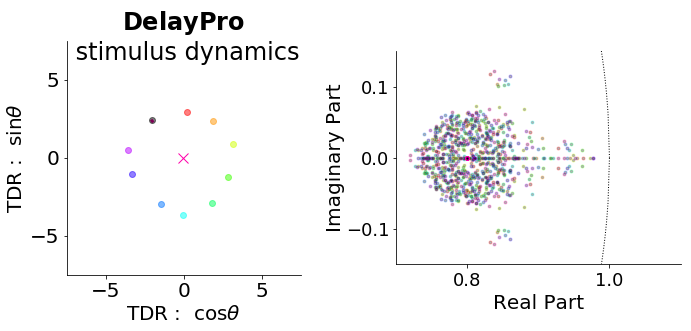

In [10]:
plt.rcParams.update({'font.size': 20})

stim_theta = 0
rule = 'fdgo'
epoch = 'stim1'
h,trial,tasks = make_h_trial_rule(m,mode = 'test')
B = generate_Beta_epoch(h[rule],trial[rule],ind = -1)
D_use = B[epoch]
lim = 7.5
t_set = range(0,80,8)
ax = plot_epoch_dynamics_animate(m,fp_file,epoch,h,trial,rule,D_use,t_set,lim = lim)

In [ ]:
rule = 'fdanti'
epoch = 'go1'
w_in, b_in, w_out, b_out = get_model_params(m)
D_use = w_out[:,1:]
lim = 2
plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,[stim_theta,],lim = 1.5,ax_type = 'out')

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()

In [ ]:
rule = 'delayanti'
epoch = 'stim1'
# h,trial,tasks = make_h_trial_rule(m)
B = generate_Beta_epoch(h[rule],trial[rule],ind = -1)
D_use = B[epoch]
lim = 8.5
plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,[stim_theta,],lim = lim)

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()

In [ ]:
rule = 'delayanti'
epoch = 'delay1'
axes_epoch = 'stim1'
ax_type= 'tdr'
# h,trial,tasks = make_h_trial_rule(m)
B = generate_Beta_epoch(h[rule],trial[rule],ind = -1)
D_use = B[axes_epoch]
lim = 8.5
ax = plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,[stim_theta,],lim = lim,epoch_axes = axes_epoch)

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch + '_' + ax_type +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch + '_' + ax_type +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()

In [ ]:
rule = 'delayanti'
epoch = 'go1'
w_in, b_in, w_out, b_out = get_model_params(m)
D_use = w_out[:,1:]
plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,[stim_theta,],ax_type = 'out')

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()

In [ ]:
rule = 'delayanti'
epoch = 'delay1'
epoch_axes = 'go1'
ax_type = 'mix'
w_in, b_in, w_out, b_out = get_model_params(m)
B = generate_Beta_epoch(h[rule],trial[rule],ind = 0)
D_use = np.concatenate((B[epoch_axes][:,1][:,np.newaxis],w_out[:,2][:,np.newaxis]),axis = 1)
lim = 6.5
ax = plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,y_set = [stim_theta,],plot_eigenspect = False, lim = lim,
                    ax_type = 'mix',epoch_axes = 'stim1')
# ax.set_aspect('equal')

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch + '_' + ax_type +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch + '_' + ax_type +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()

In [ ]:
rule = 'delayanti'
epoch = 'go1'
epoch_axes = 'go1'
ax_type = 'mix'
w_in, b_in, w_out, b_out = get_model_params(m)
B = generate_Beta_epoch(h[rule],trial[rule],ind = 0)
D_use = np.concatenate((B[epoch_axes][:,1][:,np.newaxis],w_out[:,2][:,np.newaxis]),axis = 1)
plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,y_set = [stim_theta,],plot_eigenspect = False, lim = 6.5,
                    ax_type = 'mix',epoch_axes = 'stim1')

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch + '_' + ax_type +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch + '_' + ax_type +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()